# Debugging a Strategy
Our [crossover strategy from before](https://simple-back.readthedocs.io/en/latest/intro/quickstart.html) does not seem to work. To improve upon your strategies, it can be helpful to visualize them.

First, we create our `builder` object again.

In [1]:
%xmode Minimal

Exception reporting mode: Minimal


In [2]:
from simple_back.backtester import BacktesterBuilder

builder = (
   BacktesterBuilder()
   .name('JNUG 20-Day Crossover')
   .balance(10_000)
   .calendar('NYSE')
   .compare(['JNUG']) # strategies to compare with
   .live_progress() # show a progress bar using tqdm
   .live_plot(metric='Total Return (%)', min_y=None) # we assume we are running this in a Jupyter Notebook
)

## Plotting Additional Metrics
Now, we can start by logging the moving average and price of **JNUG** with `.Backtester.add_metric`{.interpreted-text role="meth"}.

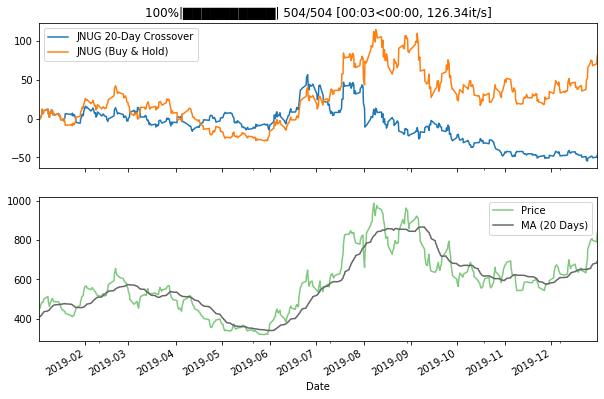

In [3]:
bt = builder.build()

for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()
        b.add_metric('Price', b.price('JNUG'))
        b.add_metric('MA (20 Days)', jnug_ma)

        if b.price('JNUG') > jnug_ma:
            if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                b.long('JNUG', percent=1) # long JNUG

        if b.price('JNUG') < jnug_ma:
            if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                b.short('JNUG', percent=1) # short JNUG

In [4]:
bt.summary

,Max Drawdown (%),Annual Return,Portfolio Value (Last Value),Total Value (Last Value),Total Return (%) (Last Value),Daily Profit/Loss (Last Value)
Backtest,,,,,,
JNUG 20-Day Crossover,-71.121124,0.525525,4993.212891,5276.118290,-47.238817,-22.133789
JNUG (Buy & Hold),-49.921226,1.799052,17476.245117,17925.556025,79.255560,-77.468262


## Plotting Lines
We can see that the moving average crosses the price many times, causing buy and sell signals just because of noise. We will try to calculate the average of 60 instead of 20 days instead, in the hope of crossover events being fewer and more meaningful. We will also use `.Backtester.add_line`{.interpreted-text role="meth"} to draw a *green line* when we go long and a *red line* when we short.

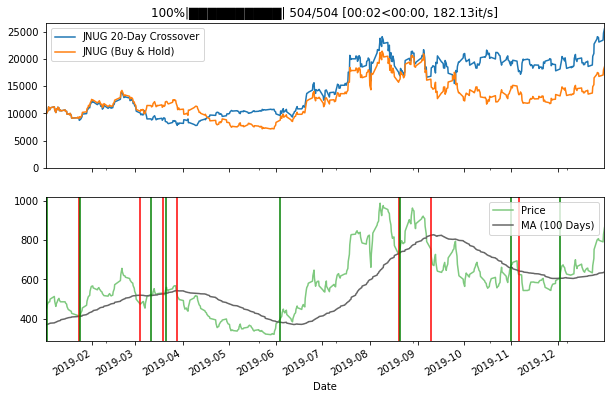

In [5]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-60:]['close'].mean()
        b.add_metric('Price', b.price('JNUG'))
        b.add_metric('MA (100 Days)', jnug_ma)

        if b.price('JNUG') > jnug_ma:
            if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                b.add_line(c='green')
                b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                b.long('JNUG', percent=1) # long JNUG

        if b.price('JNUG') < jnug_ma:
            if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                b.add_line(c='red')
                b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                b.short('JNUG', percent=1) # short JNUG

In [6]:
bt.summary

,Max Drawdown,Annual Return,Portfolio Value (Last Value),Total Value (Last Value),Daily Profit/Loss (Last Value)
Backtest,,,,,
JNUG 20-Day Crossover,-3932.812380,2.481914,24133.862305,24680.546328,-106.979980
JNUG (Buy & Hold),-3441.210832,1.799052,17476.245117,17925.556025,-77.468262


The strategy does now slightly outperform just buying and holding **JNUG**. But thanks to `add_line`, we see that it is very likely for many signals to be triggered in a row. Let's try to implement a "cooldown" after a signal is triggered. Whenever we long/short due to a signal, we will wait 60 days before considering other signals.

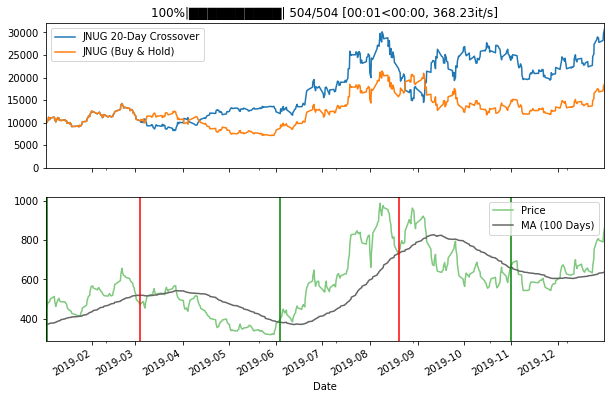

In [7]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-60:]['close'].mean()
        b.add_metric('Price', b.price('JNUG'))
        b.add_metric('MA (100 Days)', jnug_ma)

        last_pos_date = b.portfolio.attr('date')
        if last_pos_date is None:
            date_diff = 60
        else:
            date_diff = (day - last_pos_date).days
        
        if date_diff >= 60:
            if b.price('JNUG') > jnug_ma:
                if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                    b.add_line(c='green')
                    b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                    b.long('JNUG', percent=1) # long JNUG

            if b.price('JNUG') < jnug_ma:
                if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                    b.add_line(c='red')
                    b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                    b.short('JNUG', percent=1) # short JNUG

In [8]:
bt.summary

,Max Drawdown,Annual Return,Portfolio Value (Last Value),Total Value (Last Value),Daily Profit/Loss (Last Value)
Backtest,,,,,
JNUG 20-Day Crossover,-4916.015475,2.987039,29127.075195,29669.710315,-129.113770
JNUG (Buy & Hold),-3441.210832,1.799052,17476.245117,17925.556025,-77.468262


## Negative Portfolio
Now the strategy is even more profitable! Of course we are overfitting to our time period here, so let's backtest all the way back to 2015 and forward to 2020 to include the market crash due to coronavirus.

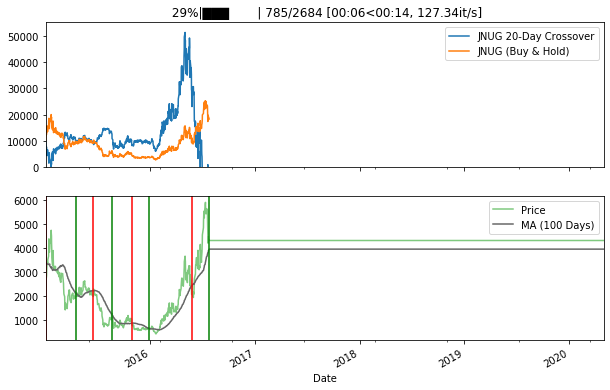

NegativeValueError: Tried to liquidate position resulting in negative capital -2483.530529785243.

In [9]:
bt = builder.build()
for day, event, b in bt['2015-1-1':'2020-5-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-60:]['close'].mean()
        b.add_metric('Price', b.price('JNUG'))
        b.add_metric('MA (100 Days)', jnug_ma)

        last_pos_date = b.portfolio.attr('date')
        if last_pos_date is None:
            date_diff = 60
        else:
            date_diff = (day - last_pos_date).days
        
        if date_diff >= 60:
            if b.price('JNUG') > jnug_ma:
                if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                    b.add_line(c='green')
                    b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                    b.long('JNUG', percent=1) # long JNUG

            if b.price('JNUG') < jnug_ma:
                if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                    b.add_line(c='red')
                    b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                    b.short('JNUG', percent=1) # short JNUG

Seems like our portfolio dips into the negative mid-2016. We can awoid this error by not liquidating when our short position is negative.

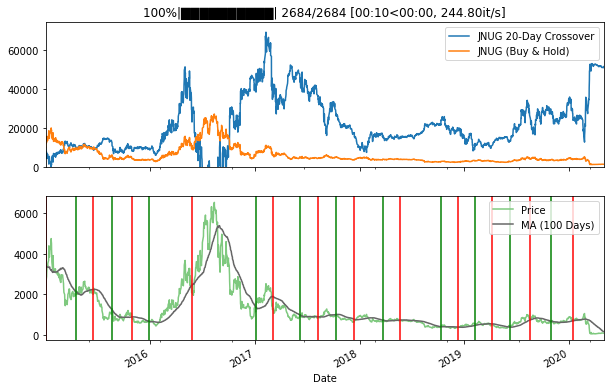

In [10]:
bt = builder.build()
for day, event, b in bt['2015-1-1':'2020-5-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-60:]['close'].mean()
        b.add_metric('Price', b.price('JNUG'))
        b.add_metric('MA (100 Days)', jnug_ma)

        last_pos_date = b.portfolio.attr('date')
        if last_pos_date is None:
            date_diff = 60
        else:
            date_diff = (day - last_pos_date).days
        
        if date_diff >= 60 and b.portfolio.value >= 0:
            if b.price('JNUG') > jnug_ma:
                if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                    b.add_line(c='green')
                    b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                    b.long('JNUG', percent=1) # long JNUG

            if b.price('JNUG') < jnug_ma:
                if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                    b.add_line(c='red')
                    b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                    b.short('JNUG', percent=1) # short JNUG

## Zooming in
The strategy does not fail anymore, but the drawdown seems significant. We can have a look at the period the plot is negative using `.Backtester.show`{.interpreted-text role="meth"}

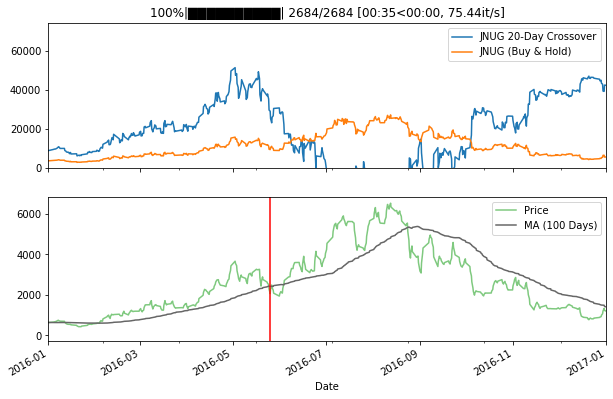

In [11]:
bt.show('2016-1-1','2017-1-1')

## Accessing Metrics
We can also check the minimum value of the backtest. There are two main ways of accessing an individual Backtests' metrics, either by using `.StrategySequence`{.interpreted-text role="class"} or by selecting its index in the full `.Backtester.metrics`{.interpreted-text role="obj"} dataframe.

In [12]:
bt.metrics.loc['JNUG 20-Day Crossover']['Total Value'].min()

-33452.41876081888

In [13]:
bt.strategies[0].metrics['Total Value'].min()

-33452.41876081888

The strategy might seem profitable, but holding a short position with a value so negative would not be possible.